In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import zscore
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import imblearn
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle

In [20]:
plt.rcParams["figure.figsize"] = [10,5]

Since manually shuffling the rows significantly improved the performance of my model, I will do it again to figure out whether or not it will improve everything again. I will take my raw data as my baseline.

# XGBoost and Naive Bayes on data-as-is

In [61]:
df = pd.read_csv('/Users/agorina/Desktop/Flatiron/Sephora_Classification/Data/True_Final_Sephora.csv')
df.head()

,Brand,Product,Price,Reviews_Count,Hearts,Clean,Allure
0,ARMANI BEAUTY,Lip Maestro Liquid Lipstick,38.0,1000.0,171.7,0,1
1,CHARLOTTE TILBURY,Matte Revolution Lipstick,34.0,719.0,135.3,0,0
2,TATCHA,The Kissu Lip Mask,28.0,262.0,41.3,1,0
3,GIVENCHY,Le Rouge Lipstick,38.0,640.0,111.2,0,0
4,NARS,Velvet Matte Lipstick Pencil,27.0,5000.0,350.4,0,0


In [3]:
X = df[['Price', 'Reviews_Count', 'Hearts', 'Clean']]
y = df['Allure']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
clf = XGBClassifier()
clf.fit(X, y)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 95.87%
Validation accuracy: 96.6%


In [7]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       482
           1       1.00      0.06      0.11        18

    accuracy                           0.97       500
   macro avg       0.98      0.53      0.54       500
weighted avg       0.97      0.97      0.95       500



In [9]:
print(metrics.confusion_matrix(y_test, test_preds))

[[482   0]
 [ 17   1]]


In [10]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 500 points : 37


Bad model! Just assumes that everything is 0, ignoring the underrepresented class. Bad, bad, naughty model!

# Shuffling

In [11]:
#split original data into two parts: winners and losers
df_lose = df[df['Allure'] == 0]
df_win = df[df['Allure'] == 1]

In [12]:
#shuffle the rows of the losing df
df_lose = shuffle(df_lose)

In [14]:
#crop the losers df so it matches the shape of the winning df
df_lose_81 = df_lose[:81]

In [15]:
#put two df together so we get a df of two equally represented classes
twodf = [df_win, df_lose_81]
edf = pd.concat(twodf, ignore_index=True)

#shuffle them again!
edf = shuffle(edf)
edf.head()

,Brand,Product,Price,Reviews_Count,Hearts,Clean,Allure
131,KEVYN AUCOIN,The Neo-Blush,38.0,40.0,12.9,0,0
126,GLAMGLOW,GLOWLACE™ Radiance-Boosting Hydration Sheet Mask,10.0,11.0,2.8,0,0
137,HUDA BEAUTY,Tantour Contour & Bronzer Cream,30.0,236.0,29.2,0,0
118,FENTY BEAUTY BY RIHANNA,Match Stix Matte Skinstick,25.0,1000.0,156000.0,0,0
139,LANEIGE,Water Bank Hydro Essence,39.0,399.0,6.4,0,0


In [17]:
edf.Allure.value_counts()
#see, equally represented

1    81
0    81
Name: Allure, dtype: int64

In [34]:
edf.shape

(162, 7)

In [18]:
#see how the classes are different in terms of varience and central tendency
aggr = edf.groupby('Allure').agg(['mean', 'std'])
aggr

Price            Reviews_Count                     Hearts  \
             mean        std          mean          std          mean   
Allure                                                                  
0       49.802346  54.131730    618.975309  1748.352624   4123.671605   
1       62.059136  85.578456   1260.061728  2669.376066  10866.644444   

                         Clean            
                 std      mean       std  
Allure                                    
0       18978.350124  0.160494  0.369350  
1       72255.936525  0.135802  0.344713

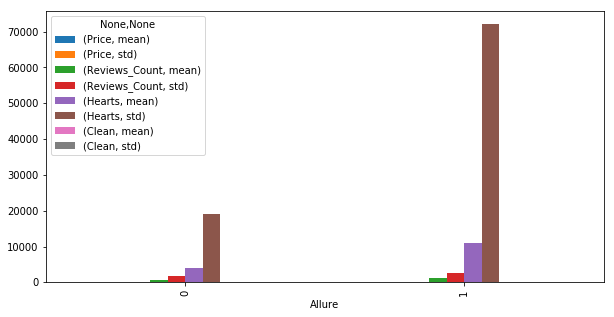

In [21]:
aggr.plot.bar()

In [35]:
#try XGBoost!
Xsh = edf[['Price', 'Reviews_Count', 'Hearts', 'Clean']]
ysh = edf['Allure']

In [36]:
Xsh_train, Xsh_test, ysh_train, ysh_test = train_test_split(Xsh, ysh, test_size=0.2, random_state=1)

In [50]:
clf = XGBClassifier()
clf.fit(Xsh, ysh)

training_preds_ = clf.predict(Xsh_train)
test_preds_ = clf.predict(Xsh_test)

training_accuracy_ = accuracy_score(ysh_train, training_preds_)
test_accuracy_ = accuracy_score(ysh_test, test_preds_)

print('Training Accuracy: {:.4}%'.format(training_accuracy_ * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy_ * 100))

Training Accuracy: 89.92%
Validation accuracy: 90.91%


In [51]:
print(classification_report(ysh_test, test_preds_))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.89      0.94      0.91        17

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33



In [52]:
print(metrics.confusion_matrix(ysh_test, test_preds_))

[[14  2]
 [ 1 16]]


In [40]:
gnb = GaussianNB()
ysh_pred = gnb.fit(Xsh_train, ysh_train).predict(Xsh_test)
print("Number of mislabeled points out of a total %d points : %d" 
      % (Xsh_test.shape[0], (ysh_test != ysh_pred).sum()))

Number of mislabeled points out of a total 33 points : 16


Unfortunateltly, Naive Bayes is not a good fit for my data.

DO it again!!

In [41]:
df.head()

,Brand,Product,Price,Reviews_Count,Hearts,Clean,Allure
0,ARMANI BEAUTY,Lip Maestro Liquid Lipstick,38.0,1000.0,171.7,0,1
1,CHARLOTTE TILBURY,Matte Revolution Lipstick,34.0,719.0,135.3,0,0
2,TATCHA,The Kissu Lip Mask,28.0,262.0,41.3,1,0
3,GIVENCHY,Le Rouge Lipstick,38.0,640.0,111.2,0,0
4,NARS,Velvet Matte Lipstick Pencil,27.0,5000.0,350.4,0,0


In [42]:
df_l = df[df['Allure'] == 0]
df_w = df[df['Allure'] == 1]

In [43]:
df_ls = shuffle(df_l)

In [44]:
df_l_81 = df_l[:81]

In [45]:
twodfs = [df_w, df_l_81]
eqdf = pd.concat(twodfs, ignore_index=True)

#shuffle them again!
eqdfs = shuffle(eqdf)
eqdfs.head()

,Brand,Product,Price,Reviews_Count,Hearts,Clean,Allure
103,GUERLAIN,Rouge G Customizable Lipstick,33.0,155.0,38.8,0,0
58,ALTERNA HAIRCARE,CAVIAR Anti-Aging® Rapid Blowout Balm,30.0,185.0,1.7,0,1
86,GUCCI,Rouge à Lèvres Mat Matte Lipstick,42.0,19.0,6.5,0,0
52,TATA HARPER,Resurfacing AHA + BHA Serum,88.0,144.0,13.4,0,1
25,ARMANI BEAUTY,Power Fabric Longwear High Cover Foundation SP...,64.0,748.0,63.5,0,1


In [46]:
Xs = eqdfs[['Price', 'Reviews_Count', 'Hearts', 'Clean']]
ys = eqdfs['Allure']

In [48]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.3, random_state=1)

In [49]:
clf = XGBClassifier()
clf.fit(Xs, ys)

training_preds__ = clf.predict(Xs_train)
test_preds__ = clf.predict(Xs_test)

training_accuracy__ = accuracy_score(ys_train, training_preds__)
test_accuracy__ = accuracy_score(ys_test, test_preds__)

print('Training Accuracy: {:.4}%'.format(training_accuracy__ * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy__ * 100))
print(classification_report(ys_test, test_preds__))
print(metrics.confusion_matrix(ys_test, test_preds__))

Training Accuracy: 90.27%
Validation accuracy: 91.84%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.89      0.89      0.89        18

    accuracy                           0.92        49
   macro avg       0.91      0.91      0.91        49
weighted avg       0.92      0.92      0.92        49

[[29  2]
 [ 2 16]]


As we can see, the model works very well on manually shuffled data. Recall went up and the main diagonal of the confusion matrix looks good, too.

# Visualizations of the equal-data

Target Variable
Allure
0    81
1    81
Name: Allure, dtype: int64


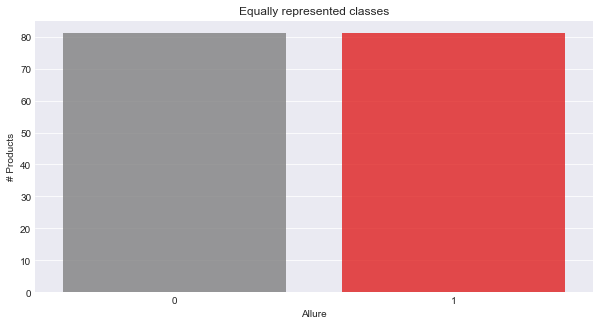

In [55]:
print('Target Variable')
print(edf.groupby(['Allure']).Allure.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(edf['Allure'], alpha =.80, palette= ['grey','red'])
plt.title('Equally represented classes')
plt.ylabel('# Products')
plt.show()

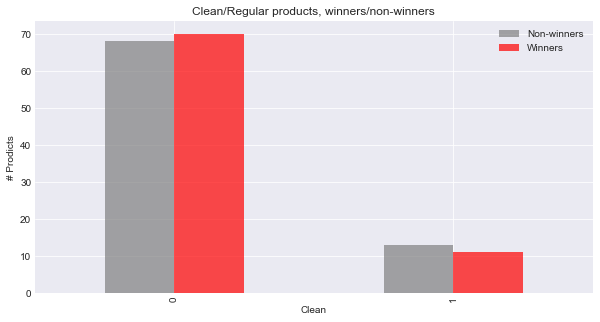

In [57]:
cleanp = edf.groupby(['Clean','Allure']).Clean.count().unstack()
p1 = cleanp.plot(kind = 'bar', stacked = False, 
                   title = 'Clean/Regular products, winners/non-winners', 
                   color = ['grey','red'], alpha = .70)
p1.set_xlabel('Clean')
p1.set_ylabel('# Prodicts')
p1.legend(['Non-winners','Winners'])
plt.show()

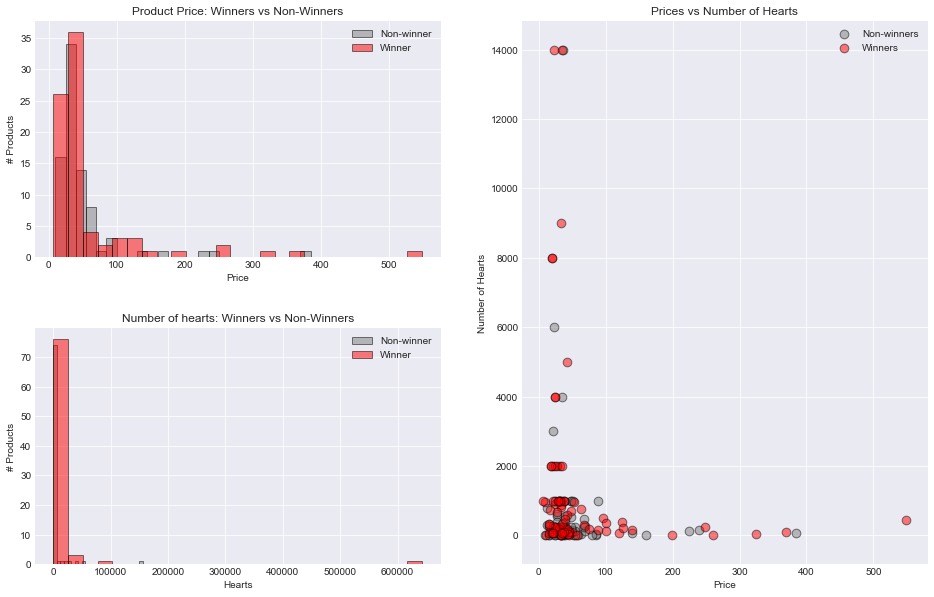

In [60]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(edf[edf['Allure'] ==0].Price, bins = 25, label ='Non-winner', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(edf[edf['Allure']==1].Price, bins = 25, label = 'Winner', alpha = .50, edgecolor = 'black',color = 'red')
ax1.set_title('Product Price: Winners vs Non-Winners')
ax1.set_xlabel('Price')
ax1.set_ylabel('# Products')
ax1.legend(loc = 'upper right')

ax2 = fig.add_subplot(223)
ax2.hist(edf[edf['Allure']==0].Hearts, bins = 25, label = 'Non-winner', alpha = .50, edgecolor ='black', color = 'grey')
ax2.hist(edf[edf['Allure']==1].Hearts, bins = 25, label = 'Winner', alpha = .50, edgecolor = 'black',color ='red')
ax2.set_title('Number of hearts: Winners vs Non-Winners')
ax2.set_xlabel('Hearts')
ax2.set_ylabel('# Products')
ax2.legend(loc = 'upper right')

ax3 = fig.add_subplot(122)
ax3.scatter(x = edf[edf['Allure']==0].Price, y = edf[edf['Allure']==0].Reviews_Count, alpha = .50, edgecolor= 'black',  c = 'grey', s= 75, label = 'Non-winners')
ax3.scatter(x = edf[edf['Allure']==1].Price, y = edf[edf['Allure']==1].Reviews_Count, alpha = .50, edgecolors= 'black',  c = 'red', s= 75, label = 'Winners')
ax3.set_xlabel('Price')
ax3.set_ylabel('Number of Hearts')
ax3.set_title('Prices vs Number of Hearts')
ax3.legend()

plt.show()